# ACS catalogue demo

In [1]:
import glob
import pathlib
import traceback
from datetime import datetime
import intake

import xarray as xr
from matplotlib import pyplot as plt

In [4]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33669,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:44575,Total threads: 1
Dashboard: /proxy/36531/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:38641,


### ignore warnings

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Load ccam_noresm2-mm_historical_aus-10i_12km

In [6]:
data_catalog_hist = intake.open_esm_datastore('/g/data/v14/tm4888/code/ACS/data-catalogue/catalogues/ccam_noresm2-mm_historical_aus-10i_12km.json')
data_catalog_hist

,unique
variable,176
domain,1
host_GCM,1
run_type,1
host_ensemble,1
downscale_model,1
downscale_version,1
period,4
time_period,4
path,32960


In [7]:
data_catalog_ssp126 = intake.open_esm_datastore('/g/data/v14/tm4888/code/ACS/data-catalogue/catalogues/ccam_noresm2-mm_ssp126_aus-10i_12km.json')
data_catalog_ssp126

,unique
variable,176
domain,1
host_GCM,1
run_type,1
host_ensemble,1
downscale_model,1
downscale_version,1
period,4
time_period,4
path,43757


# load monthly surface air temperature for both historical and ssp126

In [8]:
TAS_month_hist = data_catalog_hist.search(variable=['tas'],period='mon')
TAS_month_ssp126 = data_catalog_ssp126.search(variable=['tas'],period='mon')

In [9]:
DS_dict_hist = TAS_month_hist.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'domain.host_GCM.run_type.host_ensemble.downscale_model.downscale_version.period'


In [10]:
DS_dict_ssp126 = TAS_month_ssp126.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'domain.host_GCM.run_type.host_ensemble.downscale_model.downscale_version.period'


HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 494 in H5O__attr_open_by_name(): can't locate attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Object not found
HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 1:
  #000: H5A.c line 528 in H5Ao

In [15]:
ssp126_keys = list(DS_dict_ssp126.keys())
hist_keys = list(DS_dict_hist.keys())

In [16]:
ssp126_keys

['AUS-10i.NCC-NorESM2-MM.ssp126.r1i1p1f1.CSIRO-CCAM-2203.v1.mon']

In [17]:
DS_ssp126 = DS_dict_ssp126[ssp126_keys[0]]
DS_hist = DS_dict_hist[hist_keys[0]]

In [18]:
DS_hist

<xarray.Dataset>
Dimensions:   (time: 768, lat: 611, lon: 928, bnds: 2)
Coordinates:
  * time      (time) object 1951-01-15 12:00:00 ... 2014-12-15 12:00:00
    lat_bnds  (lat, bnds) float32 dask.array<chunksize=(611, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float32 dask.array<chunksize=(928, 2), meta=np.ndarray>
  * lon       (lon) float64 89.3 89.4 89.5 89.6 89.7 ... 181.7 181.8 181.9 182.0
  * lat       (lat) float64 -52.3 -52.2 -52.1 -52.0 -51.9 ... 8.4 8.5 8.6 8.7
Dimensions without coordinates: bnds
Data variables:
    tas       (time, lat, lon) float32 dask.array<chunksize=(12, 611, 928), meta=np.ndarray>
Attributes: (12/29)
    axiom_version:                       0.1.0
    axiom_schemas_version:               0.1.0
    axiom_schema:                        CORDEX
    contact:                             Marcus Thatcher (Marcus.Thatcher@csi...
    Conventions:                         CF-1.7
    CORDEX_domain:                       AUS-10i
    ...                                  ...
    intake_esm_attrs:downscale_model:    CSIRO-CCAM-2203
    intake_esm_attrs:downscale_version:  v1
    intake_esm_attrs:period:             mon
    intake_esm_attrs:time_period:        monthly
    intake_esm_attrs:_data_format_:      netcdf
    intake_esm_dataset_key:              AUS-10i.NCC-NorESM2-MM.historical.r1...

# do some basic comparisons

### Time mean TAS SSP126 - Historical

In [19]:
hist_tas_mean = DS_hist.tas.mean('time')
ssp126_tas_mean = DS_ssp126.tas.mean('time')                         

In [20]:
diff_tas_mean = ssp126_tas_mean - hist_tas_mean
diff_tas_mean = diff_tas_mean.compute()

Text(0.5, 1.0, 'Time mean TAS SSP126 - Historical')

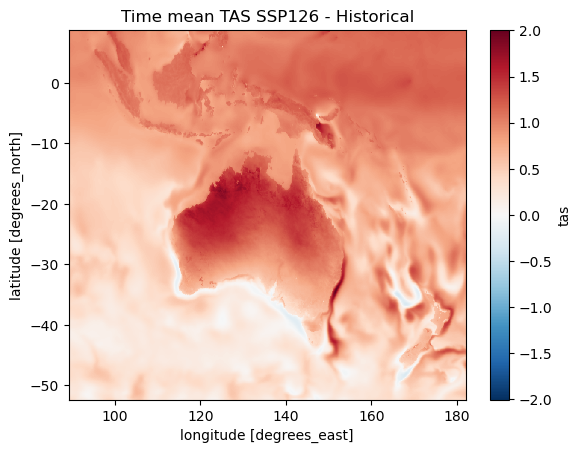

In [21]:
diff_tas_mean.plot()
plt.title('Time mean TAS SSP126 - Historical')


### climatology

In [22]:
%%time
hist_season = DS_hist.tas.groupby('time.season').mean('time').compute()
ssp126_season = DS_ssp126.tas.groupby('time.season').mean('time').compute()

CPU times: user 2.04 s, sys: 223 ms, total: 2.27 s
Wall time: 21.1 s


In [23]:
DJF_diff = ssp126_season.sel(season='DJF') - hist_season.sel(season='DJF')
DJF_diff = DJF_diff.compute()

Text(0.5, 1.0, 'DJF season : SSP126 - Historical')

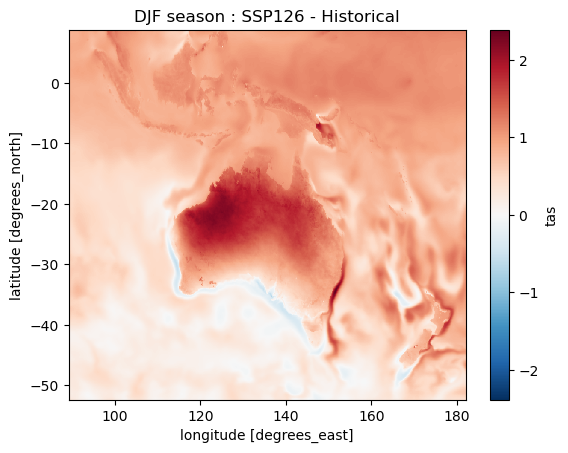

In [24]:
DJF_diff.plot()
plt.title('DJF season : SSP126 - Historical')

# can we load from the nested catalogue?

In [25]:
root_cat= intake.open_catalog('/g/data/v14/tm4888/code/ACS/data-catalogue/catalogues/nested_test/ACS_root_catalogue.yaml')

In [26]:
root_cat

ACS_root_catalogue:
  args:
    path: /g/data/v14/tm4888/code/ACS/data-catalogue/catalogues/nested_test/ACS_root_catalogue.yaml
  description: root catalogue for ACS test
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    title: txt
    title2: txt2


In [27]:
root_cat.ccam_noresm2_mm_ssp126_aus_10i_12km

TypeError: esm_datastore.__init__() got an unexpected keyword argument 'metadata'

In [ ]:
data_catalog.df

In [ ]:
data_catalog.df.variable.unique()

In [ ]:
data_catalog.df.period.unique()

In [ ]:
search1 = data_catalog.search(variable=['tas'],period='mon')
search1

In [ ]:
search1.df

In [ ]:
%%time
dsets = search1.to_dataset_dict()

In [ ]:
dsets.keys()

In [ ]:
search_DS = dsets['AUS-10i.NCC-NorESM2-MM.historical.r1i1p1f1.CSIRO-CCAM-2203.v1.mon']

In [ ]:
search_DS

In [ ]:
mean_tas = search_DS.tas.mean(dim='time')
mean_tas

In [ ]:
%%time
mean_tas = mean_tas.compute()

In [ ]:
mean_temp = mean_tas - 273.15

In [ ]:
mean_temp.plot(robust=True)
plt.title('Mean Near-Surface Air Temperature in degrees C for \n AUS-10i.NCC-NorESM2-MM.historical.r1i1p1f1.CSIRO-CCAM-2203.v1.mon')

# seasonal climatology

In [ ]:
tas_season_mean = search_DS.tas.groupby('time.season').mean('time')

In [ ]:
tas_season_mean

In [ ]:
temp_season_mean = tas_season_mean-273.15

In [ ]:
temp_season_mean

In [ ]:
temp_season_mean.sel(season='JJA').plot(robust=True)
plt.title('Winter(JJA) Near-Surface Air Temperature in degrees C for \n AUS-10i.NCC-NorESM2-MM.historical.r1i1p1f1.CSIRO-CCAM-2203.v1.mon')

In [ ]:
client.close()